In [45]:
import os
import time

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import torchvision.utils as tvutils

# import cv2
# import PIL
# import matplotlib.pyplot as plt

from my_utils import data, models
from my_utils.utils import save_model, check_accuracy, train
from my_utils.vis import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots

# life save magic code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
UseGPU = torch.cuda.is_available()
device = torch.device("cuda" if UseGPU else "cpu")
print(f"Using {device} now!")
print(f"torch version: {torch.__version__}")
if UseGPU:
    print(f"CUDA version: {torch.cuda_version}")

Using cuda now!
torch version: 1.10.0+cu113
CUDA version: 11.3


In [15]:
batch_size = 128
fig_resize = 32
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((fig_resize, fig_resize))
])
loader_kwargs = {
    'batch_size': batch_size,   # default:1
    'shuffle': True,            # default:False
    'num_workers': 4,           # default:0
    'pin_memory': False,        # default:False
    'drop_last': True,          # default:False
    'prefetch_factor': 4,       # default:2
    'persistent_workers': False # default:False
}

In [16]:
# 制作二进制数据集
train_data = data.MyDataset('Datasets/polygons_unfilled_32/train', transform=T)
train_loader = DataLoader(train_data, **loader_kwargs)

val_data = data.MyDataset('Datasets/polygons_unfilled_32/val', transform=T)
val_loader = DataLoader(val_data, **loader_kwargs)

test_data = data.MyDataset('Datasets/polygons_unfilled_32/test', transform=T)
test_loader = DataLoader(test_data, **loader_kwargs)

In [17]:
sample_step = 10

small_train_data = Subset(train_data, torch.arange(0, len(train_data) - 1, sample_step))
small_train_loader = DataLoader(small_train_data, **loader_kwargs)

small_val_data = Subset(val_data, torch.arange(0, len(val_data) - 1, sample_step))
small_val_loader = DataLoader(small_val_data, **loader_kwargs)

In [18]:
# check data before training!
img, label = train_data[0]
print(len(train_data), '\t', img.shape)
imgs, labels = next(iter(train_loader))
print(len(train_loader), '\t', imgs.shape)

img, label = val_data[0]
print(len(val_data), '\t', img.shape)
imgs, labels = next(iter(val_loader))
print(len(val_loader), '\t', imgs.shape)

40000 	 torch.Size([1, 32, 32])
312 	 torch.Size([128, 1, 32, 32])
8000 	 torch.Size([1, 32, 32])
62 	 torch.Size([128, 1, 32, 32])


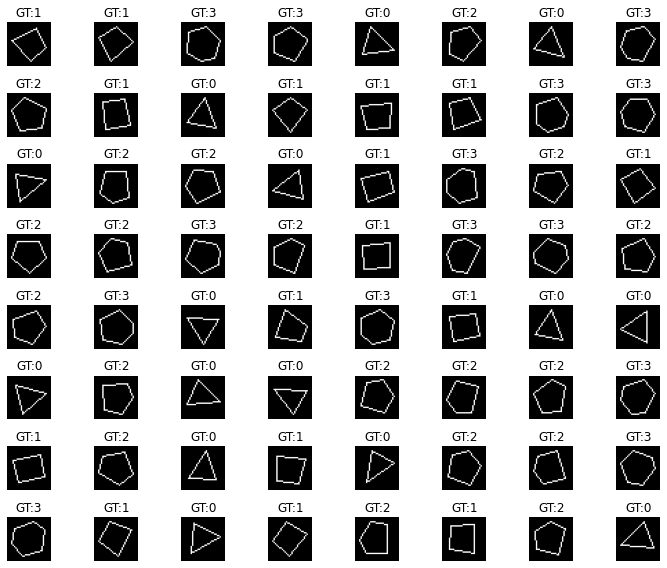

In [19]:
grid_vis(test_loader, 8)

In [ ]:
imgs_grid = tvutils.make_grid(imgs[:36], nrow=6, padding=1, pad_value=1)
plt.imshow(imgs_grid.permute(1,2,0))
plt.show()

In [61]:
model = models.simple_Conv(in_chans=1, num_classes=4, depths=(2, 2, 2) ).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=0.05)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
loss_func = nn.CrossEntropyLoss()

In [12]:
# copy the following line to prompt line!
# tensorboard --logdir runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [38]:
# writer = SummaryWriter()
# writer.add_graph(model, torch.rand([1, 1, 32, 32], device=device))

In [62]:
# reset train history
batch_step = 0
writer = SummaryWriter()

In [17]:
# Train and test!
check_loaders = {'train':small_train_loader,
                 'val':small_val_loader}

In [65]:
batch_step = train(model, optimizer, scheduler, loss_func, train_loader,
                   check_fn=check_accuracy,
                   check_loaders=check_loaders,
                   batch_step=batch_step, epochs=100, log_every=50, writer=writer)

Epoch: 1 [0/40000 (0%)]	Loss: 0.78714	Val acc: 77.5%
Epoch: 1 [6400/40000 (16%)]	Loss: 0.81233	Val acc: 83.3%
Epoch: 1 [12800/40000 (32%)]	Loss: 0.79786	Val acc: 76.2%
Epoch: 1 [19200/40000 (48%)]	Loss: 0.84636	Val acc: 81.1%
Epoch: 1 [25600/40000 (64%)]	Loss: 0.82304	Val acc: 83.9%
Epoch: 1 [32000/40000 (80%)]	Loss: 0.79536	Val acc: 79.0%
Epoch: 1 [38400/40000 (96%)]	Loss: 0.78525	Val acc: 81.6%
====> Epoch: 1	Time: 5.005757808685303s
Epoch: 2 [0/40000 (0%)]	Loss: 0.83066	Val acc: 79.2%
Epoch: 2 [6400/40000 (16%)]	Loss: 0.81283	Val acc: 91.1%
Epoch: 2 [12800/40000 (32%)]	Loss: 0.80986	Val acc: 78.5%
Epoch: 2 [19200/40000 (48%)]	Loss: 0.79462	Val acc: 79.0%
Epoch: 2 [25600/40000 (64%)]	Loss: 0.78640	Val acc: 78.1%
Epoch: 2 [32000/40000 (80%)]	Loss: 0.82996	Val acc: 78.1%
Epoch: 2 [38400/40000 (96%)]	Loss: 0.79812	Val acc: 79.2%
====> Epoch: 2	Time: 4.884169340133667s
Epoch: 3 [0/40000 (0%)]	Loss: 0.79592	Val acc: 76.6%
Epoch: 3 [6400/40000 (16%)]	Loss: 0.80777	Val acc: 83.1%
Epoch: 3 [

In [66]:
writer.close()

In [67]:
model.eval()
test_acc = check_accuracy(model, test_loader)
print('Test accuracy is : %.2f%%' % (100. * test_acc))

Test accuracy is : 82.55%


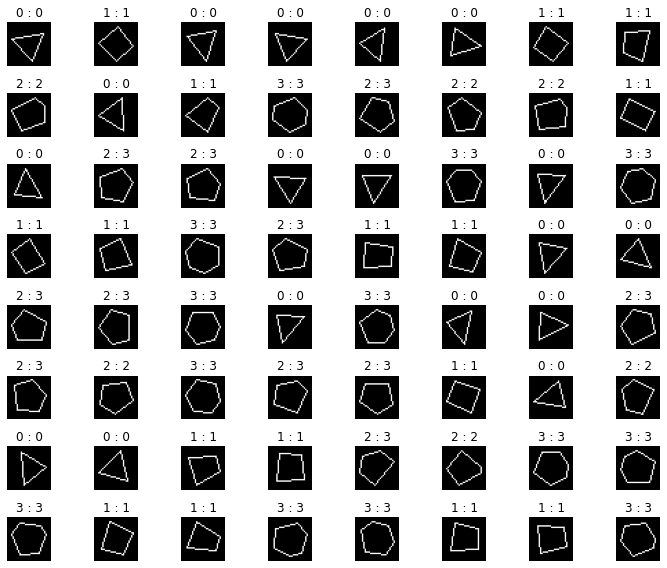

In [70]:
grid_vis(test_loader, 8, model)

In [22]:
# Save model
save_model(model, optimizer, model_type='myconvnext', acc=90)

Model parameters:
connection_layers.0.weight:	 torch.Size([8, 1])
connection_layers.0.bias:	 torch.Size([8])
connection_layers.1.weight:	 torch.Size([16, 8])
connection_layers.1.bias:	 torch.Size([16])
connection_layers.2.weight:	 torch.Size([32, 16])
connection_layers.2.bias:	 torch.Size([32])
norm_layers.0.weight:	 torch.Size([8])
norm_layers.0.bias:	 torch.Size([8])
norm_layers.0.running_mean:	 torch.Size([8])
norm_layers.0.running_var:	 torch.Size([8])
norm_layers.0.num_batches_tracked:	 torch.Size([])
norm_layers.1.weight:	 torch.Size([8])
norm_layers.1.bias:	 torch.Size([8])
norm_layers.1.running_mean:	 torch.Size([8])
norm_layers.1.running_var:	 torch.Size([8])
norm_layers.1.num_batches_tracked:	 torch.Size([])
norm_layers.2.weight:	 torch.Size([16])
norm_layers.2.bias:	 torch.Size([16])
norm_layers.2.running_mean:	 torch.Size([16])
norm_layers.2.running_var:	 torch.Size([16])
norm_layers.2.num_batches_tracked:	 torch.Size([])
stages.0.0.gamma:	 torch.Size([8])
stages.0.0.dwconv

In [27]:
# reload modal paras from saved .pt file
new_model = models.my_ConvNeXt()

new_model.to(device)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=1e-5, weight_decay=0.1)

save_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])
new_optimizer.load_state_dict(checkpoint["optim_paras"])

In [28]:
new_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(new_optimizer, T_0=1, T_mult=2)

In [24]:
new_model.eval()
check_accuracy(new_model, test_loader)

Test accuracy is : 96.99%	Infer time: 6.132776260375977


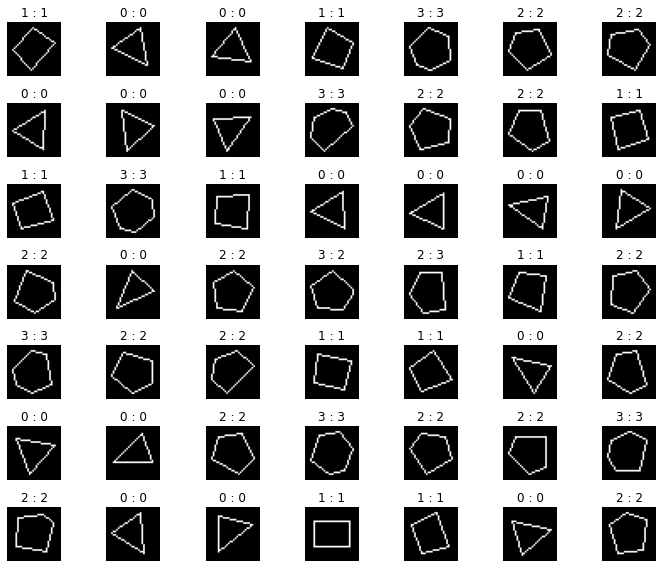

In [14]:
grid_vis(test_loader, 8, new_model)

In [28]:
vis_model = models.my_ConvNeXt_vis()
vis_model.to(device)

save_path = 'saved_models/97_polygen_unfilled_myconvnext_2022_01_21_19_58_50.pt'
checkpoint = torch.load(save_path)
new_model.load_state_dict(checkpoint["model_paras"])

<All keys matched successfully>

In [29]:
vis_model

my_ConvNeXt_vis(
  (connection_layers): ModuleList(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=32, bias=True)
  )
  (norm_layers): ModuleList(
    (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
        (norm): BatchNorm2d(8, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (pwconv1): Linear(in_features=8, out_features=16, bias=True)
        (act): ReLU()
        (pwconv2): Linear(in_features=16, out_features=8, bias=True)
      )
    )
    (1): Sequential(
      (0): B

In [56]:
img, label = test_data[2000]
img = img[None, :, :, :].to(device, dtype=torch.float32)
# label = label.to(device, dtype=torch.int64)
vis = img.permute(0, 2, 3, 1)
scores, mid_outputs = vis_model(img)

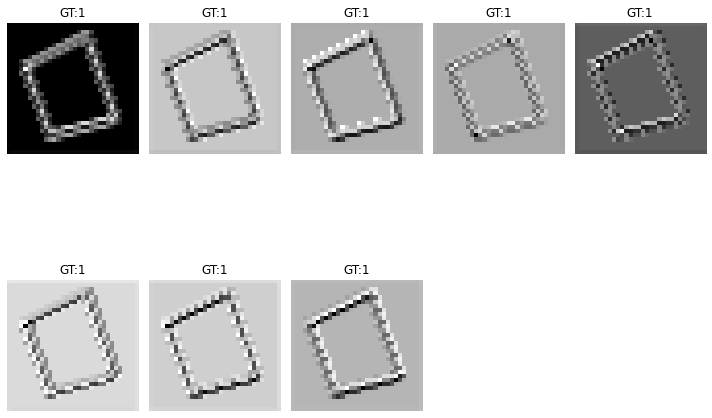

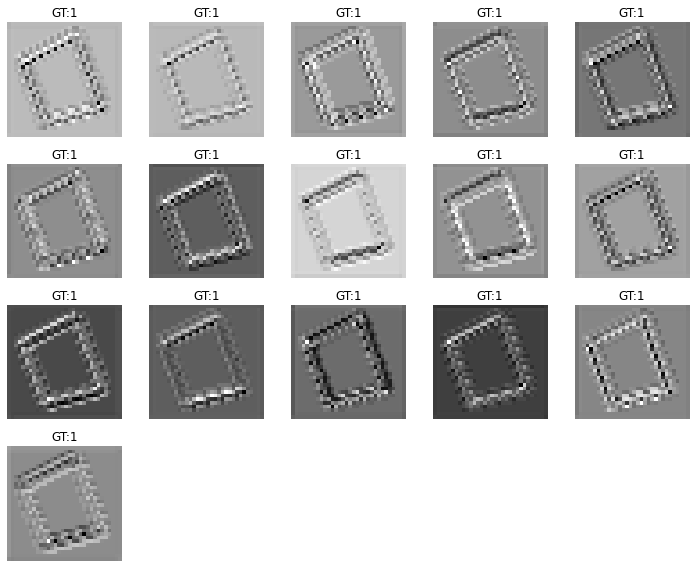

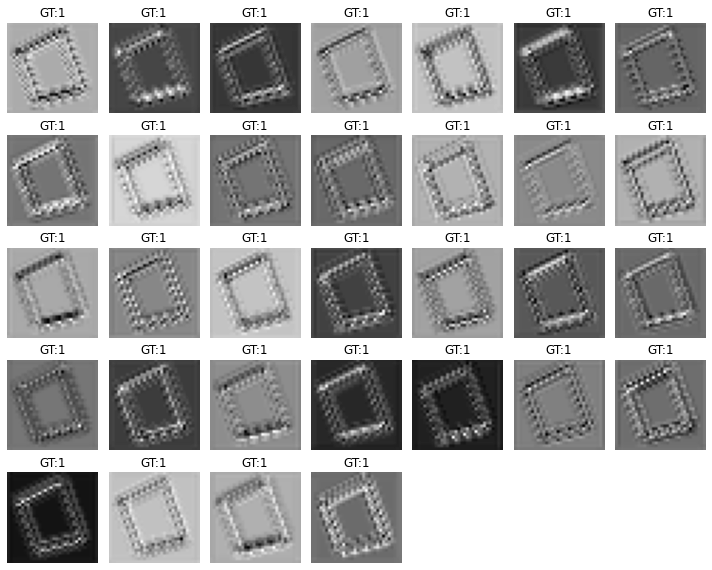

In [57]:
for act in mid_outputs:
    vis_act(act, label)